In [1]:
import numpy as np        # check NumPy
import tinyarray          # check tinyarray

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import kwant              # check Kwant core
from scipy.linalg import eigh
from scipy.constants import hbar, e, k as k_B

In [3]:
from tqdm.notebook import tqdm
import time

In [4]:
from scipy.sparse.linalg import eigsh

In [5]:
# Run this in a Jupyter cell
import sys
print(sys.executable)  # Should point to your conda environment's Python

/Users/jingyili/miniforge/envs/kwant-intel/bin/python


In [17]:
import matplotlib.pyplot as plt

In [18]:
# Constants
a = 1.0           # Lattice constant (nm)
t = 1.0           # Hopping (eV)
mu = 0.0          # Chemical potential (eV)
alpha = 0.5       # Rashba SOC (eV·nm)
h0 = 0.5          # Exchange field (eV)
W = 50e-9         # Junction width (m)
hbar = 6.582119569e-16  # eV·s (reduced Planck constant)
e = 1.602176634e-19     # C (elementary charge)
phi0 = hbar/(2*e) # Flux quantum (Wb)
k_B = 8.617333262e-5    # Boltzmann constant (eV/K)
Lx, Ly = 100, 20  # System dimensions

In [19]:
def make_system():
     # Define Pauli matrices HERE
    sigma_0 = tinyarray.array([[1, 0], [0, 1]])
    sigma_x = tinyarray.array([[0, 1], [1, 0]])
    sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
    sigma_z = tinyarray.array([[1, 0], [0, -1]])
    tau_0 = sigma_0
    tau_x = tinyarray.array([[0, 1], [1, 0]])
    tau_z = tinyarray.array([[1, 0], [0, -1]])
    
    lat = kwant.lattice.square(a, norbs=4)  # Add norbs=4
    sys = kwant.Builder()

    def onsite(site, Delta_array, phase, B):
        x, y = site.pos
        x_idx, y_idx = int(round(x/a)), int(round(y/a))
        if x < 40*a or x >= 60*a:
            # S regions: fixed Δ with phase
            Delta_val = 0.2 * np.exp(1j * phase * (-1 if x < 40*a else 1))
            h = 0.0
        else:
            # F region: use Delta_array
            Delta_val = Delta_array[x_idx, y_idx]
            h = h0 * np.tanh((x - 50*a)/(10*a))  # Domain wall
        onsite_matrix = (
            (4*t - mu) * np.kron(sigma_0, tau_z) +
            h * np.kron(sigma_z, tau_z) +
            np.real(Delta_val) * np.kron(sigma_0, tau_x) +
            np.imag(Delta_val) * np.kron(sigma_0, np.dot(tau_x, sigma_y))  # Use np.dot for matrix multiplication
        )
        return onsite_matrix

    def hopping_x(site1, site2, B):
        y = site1.pos[1]
        flux_phase = 2*np.pi * B * y * a**2 / phi0
        return (
            -t * np.kron(sigma_0, tau_z) -
            1j*alpha * np.kron(sigma_y, tau_z)
        ) * np.exp(1j*flux_phase)

    def hopping_y(site1, site2):
        return (
            -t * np.kron(sigma_0, tau_z) +
            1j*alpha * np.kron(sigma_x, tau_z)
        )

    # Build system
    sys[lat.shape((lambda pos: 0 <= pos[0] < Lx*a and 0 <= pos[1] < Ly*a), (0, 0))] = onsite
    sys[lat.neighbors()] = hopping_x
    sys[kwant.HoppingKind((0, 1), lat)] = hopping_y

    return sys.finalized()

In [20]:
# start self consistently updateing Delta, the order parameter 
def self_consistent_Delta(sys, V=1.0, T=0.01, max_iter=100, tol=1e-6, phase=0, B=0):
   # Initialization code
    print("\nStarting self-consistent calculation...")
    print(f"Target tolerance: {tol:.1e}, Max iterations: {max_iter}")
    start_time = time.time()
    
    # Initialize Δ (this should be OUTSIDE the iteration loop)

    
    Delta = np.zeros((Lx, Ly), dtype=complex)
    mask_S_left = (np.arange(Lx)*a < 40*a)
    mask_S_right = (np.arange(Lx)*a >= 60*a)

     # Initialize S regions only
    Delta[mask_S_left, :] = 0.2 * np.exp(1j * phase * -1)
    Delta[mask_S_right, :] = 0.2 * np.exp(1j * phase * 1)

     # Disable pairing in F region
    V_matrix = np.zeros((Lx, Ly))
    V_matrix[mask_S_left | mask_S_right] = V  # Pairing only in S

    # Convergence monitoring
    mask_S = mask_S_left | mask_S_right  # For convergence check
    min_iter = 20  # Minimum iterations before checking convergence
    

    # Plot initial h(x) profile
    x_positions = np.arange(Lx) * a
    h_profile = h0 * np.tanh((x_positions - 50*a)/(10*a))
    plt.figure()
    plt.plot(x_positions, h_profile)
    plt.xlabel("x (nm)")
    plt.ylabel("h(x) (eV)")
    plt.title("Exchange Field Profile")
    plt.show()

    """
    # Set up S regions (do this once before iterations)
    for x in range(Lx):
        x_pos = x * a
        for y in range(Ly):
            if x_pos < 40*a or x_pos >= 60*a:
                phase_factor = -1 if x_pos < 40*a else 1
                Delta[x, y] = 0.2 * np.exp(1j * phase * phase_factor)
    """
    
    with tqdm(total=max_iter, desc="SCF Cycle", unit="iter", 
             bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]") as pbar:
        min_iter = 20  #force the minimum iteration in case converge too fast
        # begin iteratively solving for Delta 
        for iter in range(max_iter):
            # Build Hamiltonian
            
            params = {'Delta_array': Delta, 'phase': phase, 'B': B}
            H = sys.hamiltonian_submatrix(params=params)
            eps, psi = np.linalg.eigh(H)  # Full spectrum

             # Reset order parameter and calculate new Delta for pairing in F region
            Delta_new = np.zeros_like(Delta)
            for n in range(len(eps)):  # 
                vec = psi[:, n]
                weight = np.tanh(0.5 * abs(eps[n]) / (k_B * T)) if T > 0 else 1.0
            
                for x in range(Lx):
                    for y in range(Ly):
                         # Skip F regions
                        if not (mask_S_left[x] or mask_S_right[x]):
                            continue  # Skip F regions
                        # Calculate components using correct indexing
                        idx = y + Ly * x
                        u_up = vec[4*idx]
                        u_dn = vec[4*idx + 1]
                        v_up = vec[4*idx + 2]
                        v_dn = vec[4*idx + 3]

                        # Use V_matrix for spatial-dependent pairing
                        contrib = V_matrix[x, y] * (u_up * v_dn.conj() + u_dn * v_up.conj()) * weight
                    
                        Delta_new[x, y] += contrib
                    
            
  

            # Apply linear mixing once per iteration:
            gamma = 0.1  # Mixing parameter
            Delta = gamma * Delta_new + (1 - gamma) * Delta
            # Check convergence in S regions
            max_diff = np.max(np.abs(Delta_new[mask_S] - Delta[mask_S]))
            
            pbar.set_postfix({
                'ΔΔ': f"{max_diff:.2e}",
                '|Δ|': f"{np.mean(np.abs(Delta[mask_S])):.3e}"
            })
            pbar.update(1)

            
            if (iter % 5 == 0) or (iter == max_iter-1):
                plt.figure(figsize=(12,5))
    
                plt.subplot(121)
                plt.imshow(np.abs(Delta).T, cmap='viridis', extent=[0, Lx*a, 0, Ly*a], origin='lower')
                plt.colorbar(label='|Δ(x,y)| (eV)')
                plt.xlabel("x (nm)")
                plt.ylabel("y (nm)")
                plt.title(f"Iteration {iter+1}")
    
                plt.subplot(122)
                plt.plot(x_positions, np.mean(np.abs(Delta), axis=1))
                plt.xlabel("x (nm)")
                plt.ylabel("Mean |Δ(x)|")
                plt.axvline(40*a, color='r', ls='--', label='S/F Interface')
                plt.axvline(60*a, color='r', ls='--')
                plt.legend()
    
                plt.tight_layout()
                plt.show() 

                pass

            # Convergence check
            if iter >= min_iter and max_diff < tol:
                print(f"\nConverged after {iter+1} iterations")
                break

     
    # Final plots and return
    plt.figure(figsize=(10,4))        
                
    # final reporting
    print(f"\nTotal time: {time.time()-start_time:.1f}s")
    return Delta

In [21]:
sys = make_system()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



Starting self-consistent calculation...
Target tolerance: 1.0e-06, Max iterations: 100


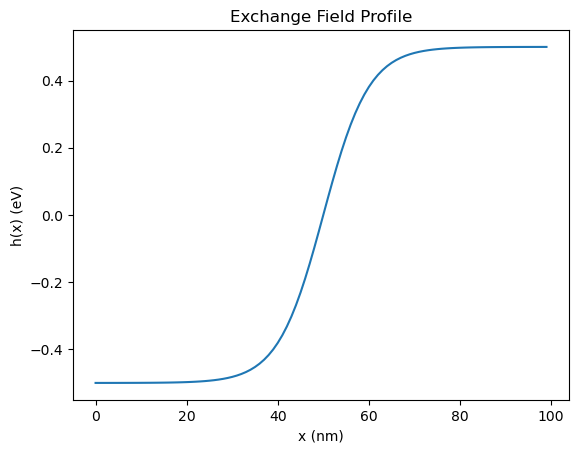

SCF Cycle:   0%|          | 0/100 [00:00<?]

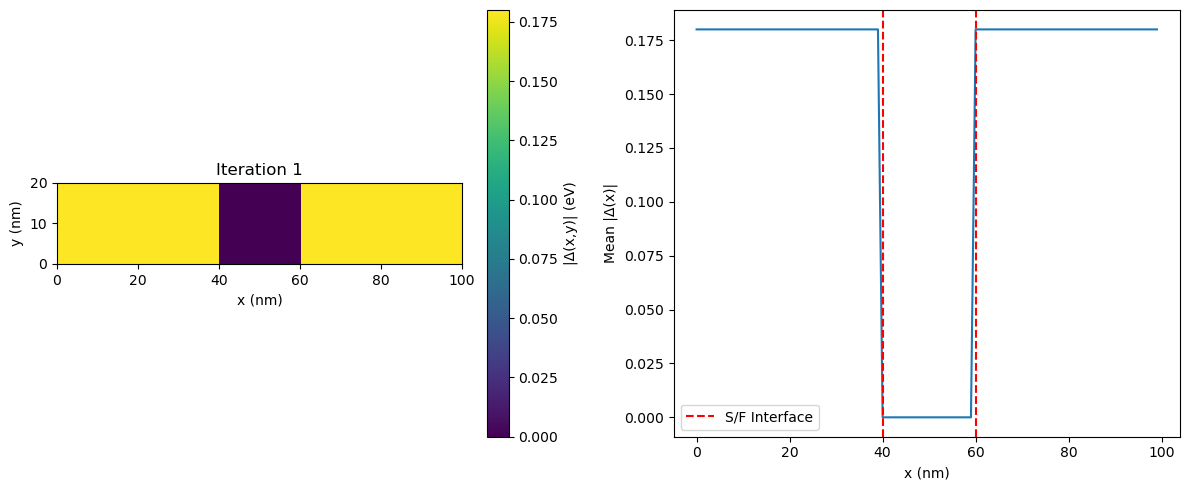

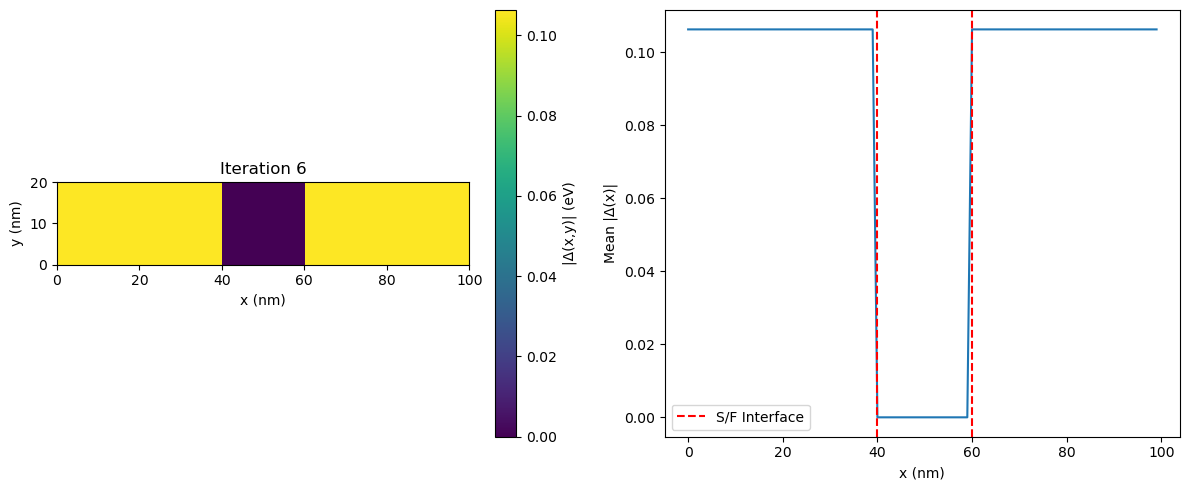

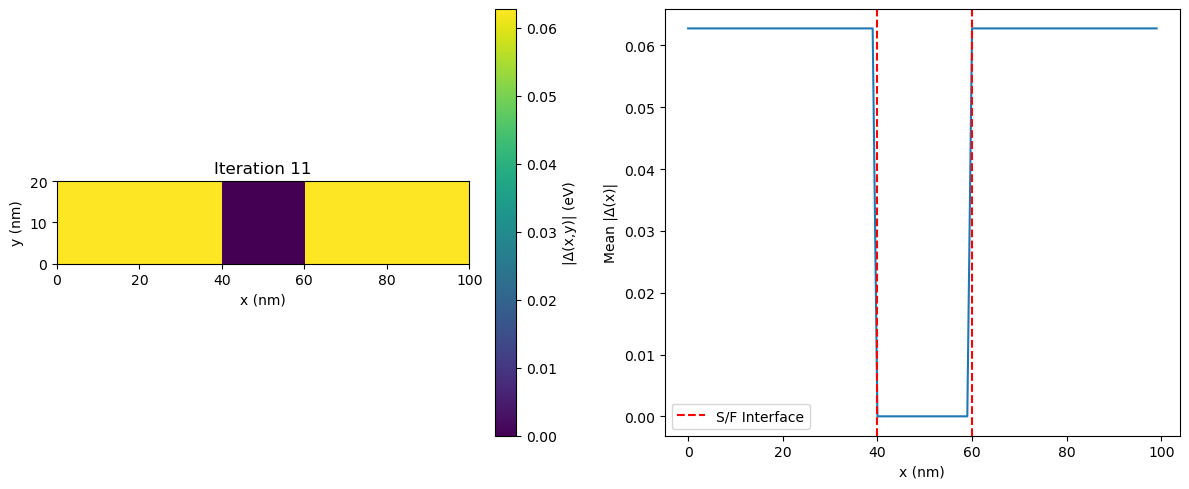

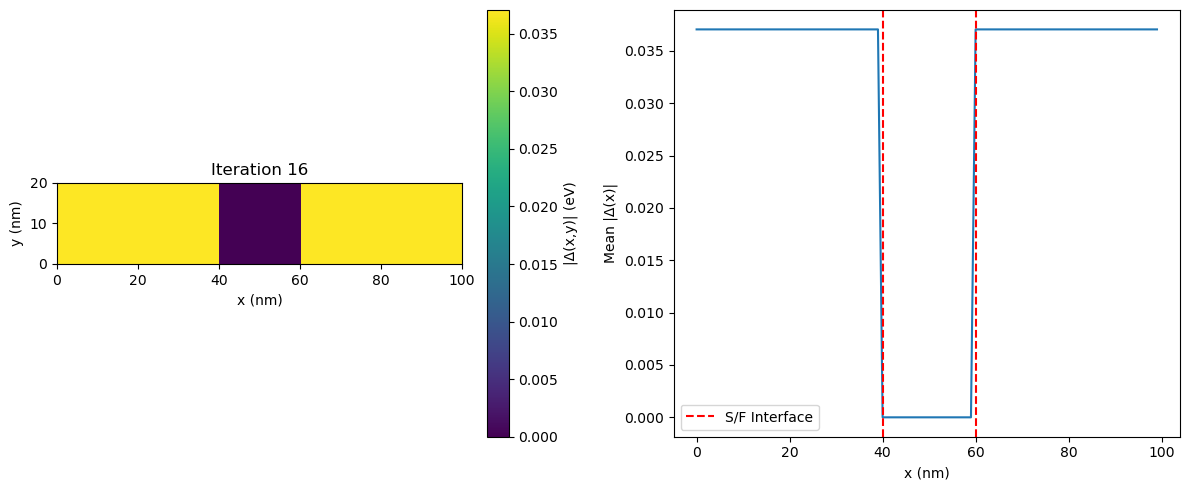

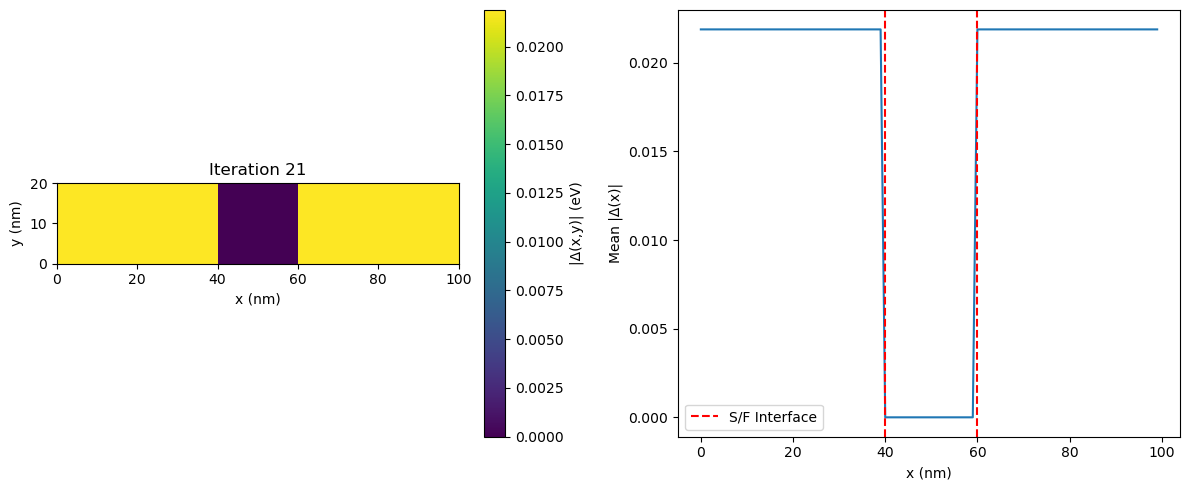

In [ ]:
Delta = self_consistent_Delta(sys, V=1.0, T=0.01, phase=0, B=0)

In [ ]:
from kwant.solvers.common import GreensFunction

def compute_current(syst, phase):
    """Komori-style current via Matsubara GF"""
    current = 0.0
    for n in range(n_matsubara):
        omega = (2*n+1)*np.pi*T
        gf = GreensFunction(syst, energy=1j*omega, params={'phase': phase})
        
        # Sum E↑↑(iω_n) over sites
        for site in syst.sites:
            e_up = 4*syst.sites.index(site)  # Spin-up electron
            h_up = e_up + 3                  # Spin-up hole
            current += gf.submatrix((e_up,), (h_up,))[0,0].imag
            
    return -2*e * 1.0 * T * current  # ν0=1, t=1



In [ ]:
# compute the critical current from the matsubara  green function
Ic = compute_current(sys.finalized(), phase=np.pi/2)

In [34]:
def compute_critical_current(B_values):
    I_c = []
    for B in B_values:
        # Self-consistent solution
        sys = make_system(B=B)
        Delta = self_consistent_Delta(sys)
        
        # Current-phase relation
        phases = np.linspace(0, 2*np.pi, 50)
        currents = []
        for phi in phases:
            sys_phi = make_system(B=B, phase=phi)
            H = sys_phi.hamiltonian_submatrix()
            eps = eigh(H, eigvals_only=True)
            E_gs = np.sum(eps[eps < 0])
            currents.append(2*e/hbar * np.gradient(E_gs, phi))
        
        I_c.append(np.max(np.abs(currents)))
    
    return np.array(I_c)

In [35]:
# Generate Fraunhofer pattern
B_values = np.linspace(-2, 2, 50)  # In units of Φ/Φ₀
I_c = compute_critical_current(B_values)

TypeError: make_system() got an unexpected keyword argument 'B'

In [ ]:

# Plot
import matplotlib.pyplot as plt
plt.plot(B_values, I_c)
plt.xlabel("Magnetic Field (Φ/Φ₀)")
plt.ylabel("Critical Current I_c")
plt.title("Asymmetric Fraunhofer Pattern")
plt.show()

In [ ]:
sys = make_system()
Delta = self_consistent_Delta(sys, V=1.0, T=0.01, phase=0, B=0)

plt.figure(figsize=(10, 6))
plt.imshow(np.abs(Delta.T), cmap='viridis', aspect='auto', 
           extent=[0, Lx*a, 0, Ly*a], origin='lower')
plt.colorbar(label=r'$|\Delta|$ (eV)')
plt.xlabel('x (nm)')
plt.ylabel('y (nm)')
plt.show()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


SCF Cycle:   0%|          | 0/100 [00:00<?]